Mount Drive and create folders

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/project"

os.makedirs(PROJECT_ROOT, exist_ok=True)
os.chdir(PROJECT_ROOT)

print("Current directory:", os.getcwd())

folders = [
    "data/raw/audio",
    "data/raw/lyrics",
    "data/processed",
    "src",
    "results/metrics",
    "results/figures",
    "notebooks",
    "tests",
    "models"
]

for f in folders:
    os.makedirs(f, exist_ok=True)

!apt-get -qq install tree
!tree -d


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/MyDrive/project
.
├── data
│   ├── processed
│   └── raw
│       ├── audio
│       └── lyrics
├── models
├── notebooks
├── results
│   ├── figures
│   └── metrics
├── src
│   └── __pycache__
├── tests
└── testsmodels

14 directories


Installing dependencies

In [ ]:
!pip install datasets librosa torch torchvision scikit-learn matplotlib sentence-transformers pandas

Imports

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import librosa
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer


Loading Dataset & Extracting Features

In [ ]:
import numpy as np
from datasets import load_dataset
from src.dataset import extract_features

dataset = load_dataset("JoshuaW1997/FUTGA", "MusicCaps", split="train")

features = []
N = 500

for i in range(N):
    features.append(extract_features(dataset[i]))

X = np.array(features)
np.save("data/processed/features.npy", X)

print("Features extracted:", X.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Features extracted: (500, 404)


In [ ]:
import torch
from src.vae import VAE
from src.train import vae_loss

X_tensor = torch.tensor(X, dtype=torch.float32)

vae = VAE(X.shape[1])
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(30):
    optimizer.zero_grad()
    recon, mu, logvar = vae(X_tensor)
    loss = vae_loss(recon, X_tensor, mu, logvar)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.4f}")

torch.save(vae.state_dict(), "models/vae.pth")
print("VAE trained & saved")


Epoch 0 | Loss 0.0152
Epoch 5 | Loss 0.0037
Epoch 10 | Loss 0.0023
Epoch 15 | Loss 0.0017
Epoch 20 | Loss 0.0014
Epoch 25 | Loss 0.0012
VAE trained & saved


Latent Extraction

In [ ]:
with torch.no_grad():
    _, mu, _ = vae(X_tensor)
    latent = mu.numpy()

np.save("data/processed/latent.npy", latent)
print("Latent vectors saved")


Latent vectors saved


Clustering & Evaluation


In [ ]:
import pandas as pd
from src.clustering import cluster_vae, cluster_pca
from src.evaluation import evaluate

labels_vae = cluster_vae(latent)
X_pca, labels_pca = cluster_pca(X)

vae_metrics = evaluate(latent, labels_vae)
pca_metrics = evaluate(X_pca, labels_pca)

df = pd.DataFrame([
    {"Method": "VAE + KMeans", **vae_metrics},
    {"Method": "PCA + KMeans", **pca_metrics}
])

df.to_csv("results/metrics.csv", index=False)
df


,Method,Silhouette,Calinski_Harabasz
0,VAE + KMeans,0.091969,61.334557
1,PCA + KMeans,0.099623,44.778757


Visualization (t-SNE)

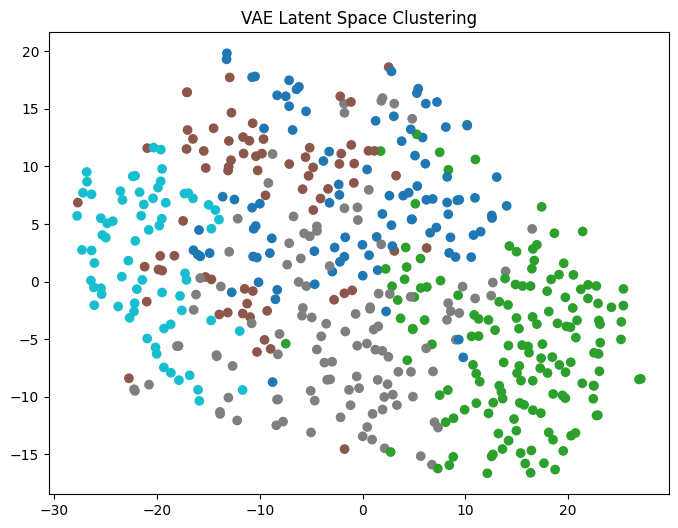

Visualization saved


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent)

plt.figure(figsize=(8,6))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=labels_vae, cmap="tab10")
plt.title("VAE Latent Space Clustering")
plt.savefig("results/figures/tsne_latent.png")
plt.show()

print("Visualization saved")


In [ ]:
readme = """
Unsupervised VAE-based Clustering of Hybrid Music Data

Dataset: FUTGA MusicCaps
Method: Variational Autoencoder + KMeans
Baseline: PCA + KMeans

Features:
- Audio MFCC
- Text caption embeddings

Metrics:
- Silhouette Score
- Calinski-Harabasz Index
"""

with open("README.md", "w") as f:
    f.write(readme)

print("README.md created")


README.md created


Hard Tasks

---

define Beta-VAE:

In [ ]:


class BetaVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16, beta=4.0):
        super().__init__()
        self.beta = beta

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def beta_vae_loss(recon, x, mu, logvar, beta=4.0):
    recon_loss = nn.MSELoss()(recon, x)
    kl = -0.5 * torch.mean(1 + logvar - mu**2 - torch.exp(logvar))
    return recon_loss + beta * kl


training Beta-VAE


In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
beta_vae = BetaVAE(input_dim=X.shape[1], latent_dim=16, beta=4.0)
optimizer = torch.optim.Adam(beta_vae.parameters(), lr=1e-3)

for epoch in range(30):
    optimizer.zero_grad()
    recon, mu, logvar = beta_vae(X_tensor)
    loss = beta_vae_loss(recon, X_tensor, mu, logvar, beta=4.0)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

torch.save(beta_vae.state_dict(), "models/beta_vae.pth")
print("Beta-VAE trained & saved")


Epoch 0 | Loss: 0.0215
Epoch 5 | Loss: 0.0051
Epoch 10 | Loss: 0.0026
Epoch 15 | Loss: 0.0018
Epoch 20 | Loss: 0.0015
Epoch 25 | Loss: 0.0012
Beta-VAE trained & saved


Beta-VAE latent vectors

In [ ]:
with torch.no_grad():
    _, mu, _ = beta_vae(X_tensor)
    latent_beta = mu.numpy()

np.save("data/processed/latent_beta.npy", latent_beta)
print("Beta-VAE latent vectors saved")


Beta-VAE latent vectors saved


Advanced clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# Agglomerative clustering
agglo_labels = AgglomerativeClustering(n_clusters=5).fit_predict(latent_beta)

dbscan_labels = DBSCAN(eps=5, min_samples=5).fit_predict(latent_beta)

print("Advanced clustering done")


Advanced clustering done


Advanced evaluation

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ARI and NMI between Beta-VAE + Agglomerative vs previous VAE + KMeans
ari_score = adjusted_rand_score(labels_vae, agglo_labels)
nmi_score = normalized_mutual_info_score(labels_vae, agglo_labels)

print(f"ARI: {ari_score:.4f}, NMI: {nmi_score:.4f}")


ARI: 0.0895, NMI: 0.1468


Visualizing Beta-VAE latent space (t-SNE)

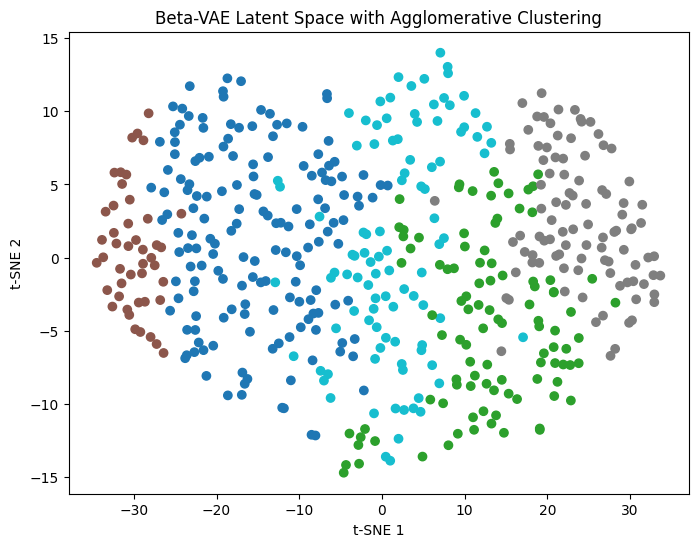

t-SNE visualization of Beta-VAE latent space done


In [ ]:


tsne = TSNE(n_components=2, random_state=42)
latent_2d_beta = tsne.fit_transform(latent_beta)

plt.figure(figsize=(8,6))
plt.scatter(latent_2d_beta[:,0], latent_2d_beta[:,1], c=agglo_labels, cmap="tab10")
plt.title("Beta-VAE Latent Space with Agglomerative Clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.savefig("results/figures/tsne_beta_vae.png")
plt.show()

print("t-SNE visualization of Beta-VAE latent space done")
